<a href="https://colab.research.google.com/github/Devi-s-naidu/Resolute_AI_software_internship/blob/main/timeseries_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as plt

In [6]:
def get_data():
  data_file = "/content/station.csv"
  f = open(data_file)
  data = f.read()
  f.close()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[2:]
  temperatures=[]
  for line in lines:
    if line:
      linedata = line.split(',')
      linedata = linedata[1:13]
      for item in linedata:
        if item:
          temperatures.append(float(item))
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype="float32")
  return time, series

In [7]:
time, series = get_data()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
out = np.logical_not(series > 200)
series=series[out]
time=time[out]

In [9]:
len(series)

657

In [10]:
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std

In [11]:
#device_name = tf.test.gpu_device_name()

In [12]:
split_time = 390
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [13]:
window_size = 48
batch_size = 12
shuffle_buffer_size = 96

In [14]:
def windowed_dataset(series, window_size,
batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1,
  drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [16]:
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [17]:
initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

In [18]:
def model_forecast(model, series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(12).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [19]:
model = tf.keras.models.Sequential([
tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, kernel_initializer=initializer),
tf.keras.layers.GRU(units=100, kernel_initializer=initializer),
tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate = 1.5e-6, momentum = 0.5),
              metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [20]:
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
29/29 [==============================] - 9s 124ms/step - loss: 2.2067 - mae: 2.6871 - val_loss: 2.5888 - val_mae: 3.0826
Epoch 2/100
29/29 [==============================] - 2s 76ms/step - loss: 2.2004 - mae: 2.6807 - val_loss: 2.5825 - val_mae: 3.0761
Epoch 3/100
29/29 [==============================] - 3s 104ms/step - loss: 2.1942 - mae: 2.6742 - val_loss: 2.5761 - val_mae: 3.0697
Epoch 4/100
29/29 [==============================] - 2s 76ms/step - loss: 2.1880 - mae: 2.6678 - val_loss: 2.5698 - val_mae: 3.0633
Epoch 5/100
29/29 [==============================] - 2s 77ms/step - loss: 2.1818 - mae: 2.6614 - val_loss: 2.5635 - val_mae: 3.0568
Epoch 6/100
29/29 [==============================] - 2s 74ms/step - loss: 2.1756 - mae: 2.6550 - val_loss: 2.5572 - val_mae: 3.0504
Epoch 7/100
29/29 [==============================] - 3s 87ms/step - loss: 2.1694 - mae: 2.6486 - val_loss: 2.5509 - val_mae: 3.0440
Epoch 8/100
29/29 [==============================] - 3s 119ms/step - loss:

In [21]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

51/51 [==============================] - 2s 21ms/step


In [22]:
forecast*=std
forecast+=mean
x_valid*=std
x_valid+=mean

In [23]:
len(forecast)

610

In [24]:
forecast = forecast[split_time-window_size+1:]

In [25]:
forecast[0]

array([22.614235], dtype=float32)

In [26]:
results = np.array(forecast)[:, 0]

In [27]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

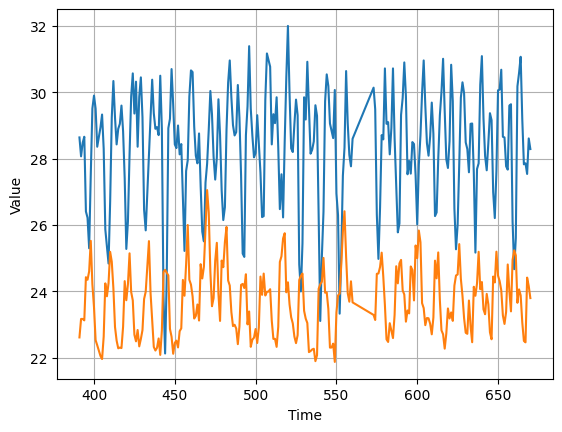

In [29]:
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
len(time_valid)

267

In [31]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

26.844015
4.6808133


In [32]:
model.save('./drive/MyDrive/timeseries_tuned.h5')

In [33]:
model = tf.keras.models.load_model('./drive/MyDrive/timeseries_tuned.h5')

In [34]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
